<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation/blob/master/src/CVAECifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
BATCH_SIZE = 100
LATENT_DIM = 3072
EPOCHS = 100

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.stats import norm
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Lambda, Reshape, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K

In [0]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

class_train_indices = np.argwhere(train_labels == 0)
class_train_images = train_images[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == 0)
class_test_images = test_images[class_test_indices[:,0]]

train_yuv  = tf.image.rgb_to_yuv(class_train_images)
train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
train_uv = train_yuv[:,:,:,1:]

test_yuv = tf.image.rgb_to_yuv(class_test_images)
test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
test_uv = test_yuv[:,:,:,1:]

In [60]:
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py
# https://xiangyutang2.github.io/auto-colorization-autoencoders/

# Sampling with the reparametrisation trick
def sample(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

yuv_in = Input(shape=(train_yuv.shape[1], train_yuv.shape[2], train_yuv.shape[3]))

# Define Training Encoder q(z|yuv)
layer = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(yuv_in)
layer = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
shape = K.int_shape(layer) # Shape before flattening

# Latent space for encoder
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
z_mean_training = Dense(LATENT_DIM)(layer)
z_log_var_training = Dense(LATENT_DIM)(layer)
z_training = Lambda(sample, output_shape=(LATENT_DIM,))([z_mean_training, z_log_var_training]) # Data passable to the decoder

# Instantiate encoder 
encoder_training = Model(yuv_in, z_training, name='training encoder')
encoder_training.summary()

Model: "training encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 16, 16, 8)    224         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 8, 8, 16)     1168        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 4, 4, 64)     9280        conv2d_21[0][0]                  
___________________________________________________________________________________

In [61]:
y_in = Input(shape=(train_y.shape[1], train_y.shape[2], train_y.shape[3]))

# Define Decoder p(uv|z,y)
latent_inputs = Input(shape=(LATENT_DIM,))
layer = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
layer = Reshape((shape[1], shape[2], shape[3]))(layer)
layer = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
uv_out = Conv2DTranspose(filters=2, kernel_size=3, activation='tanh', padding='same')(layer)
concat_outputs = concatenate([uv_out, y_in], 3)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(concat_outputs)
mean_yuv = Conv2DTranspose(filters=3, kernel_size=3, activation='tanh', padding='same')(layer)
log_sig_sqr_yuv = Conv2DTranspose(filters=3, kernel_size=3, activation='relu', padding='same')(layer)

# Instantiate Decoder
decoder = Model([latent_inputs, y_in], mean_yuv, name='decoder')
decoder.summary()
yuv_out = decoder([z_training, y_in])

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 3072)]       0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 512)          1573376     input_18[0][0]                   
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 2, 2, 128)    0           dense_23[0][0]                   
__________________________________________________________________________________________________
conv2d_transpose_40 (Conv2DTran (None, 4, 4, 128)    147584      reshape_5[0][0]                  
____________________________________________________________________________________________

In [62]:
vae = Model([yuv_in, y_in], yuv_out, name='vae')
vae.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_17:0
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 16, 16, 8)    224         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 8, 8, 16)     1168        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 4, 4, 64)     9280        co

In [63]:
reconstruction_loss = K.sum(mse(yuv_in, yuv_out))
reconstruction_loss *= (train_yuv.shape[1] * train_yuv.shape[2])
kl_loss = 1 + z_log_var_training - K.square(z_mean_training) - K.exp(z_log_var_training)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 16, 16, 8)    224         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 8, 8, 16)     1168        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 4, 4, 64)     9280        conv2d_21[0][0]                  
________________________________________________________________________________________________

In [64]:
history = vae.fit([train_yuv, train_y], shuffle=False, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([test_yuv, test_y], None))

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
5000/5000 [==============================] - 2s 385us/sample - loss: 3176365.1237 - val_loss: 994225.1500
Epoch 2/100
5000/5000 [==============================] - 1s 114us/sample - loss: 775980.0800 - val_loss: 621709.7937
Epoch 3/100
5000/5000 [==============================] - 1s 117us/sample - loss: 536194.3506 - val_loss: 443662.3563
Epoch 4/100
5000/5000 [==============================] - 1s 117us/sample - loss: 395232.5619 - val_loss: 344551.4469
Epoch 5/100
5000/5000 [==============================] - 1s 114us/sample - loss: 321760.4788 - val_loss: 294147.9813
Epoch 6/100
5000/5000 [==============================] - 1s 116us/sample - loss: 281820.8191 - val_loss: 264956.2797
Epoch 7/100
5000/5000 [==============================] - 1s 112us/sample - loss: 258229.8816 - val_loss: 241876.7406
Epoch 8/100
5000/5000 [==============================] - 1s 118us/sample - loss: 234436.1391 - val_loss: 223398.5938
Epoch 9/100
500

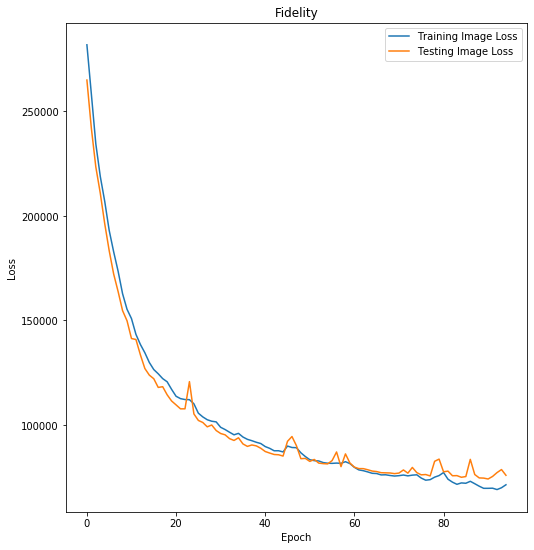

In [65]:
fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(history.history["loss"][5:], label="Training Image Loss")
plt.plot(history.history["val_loss"][5:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


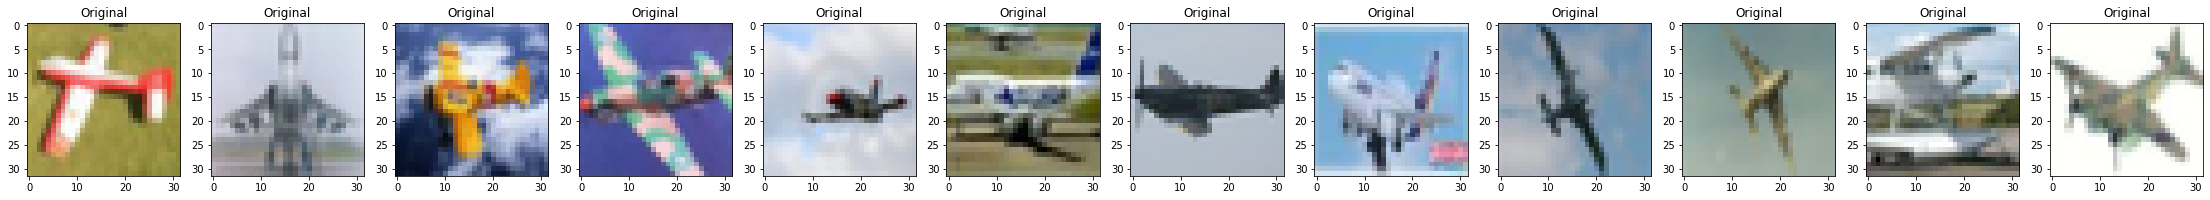

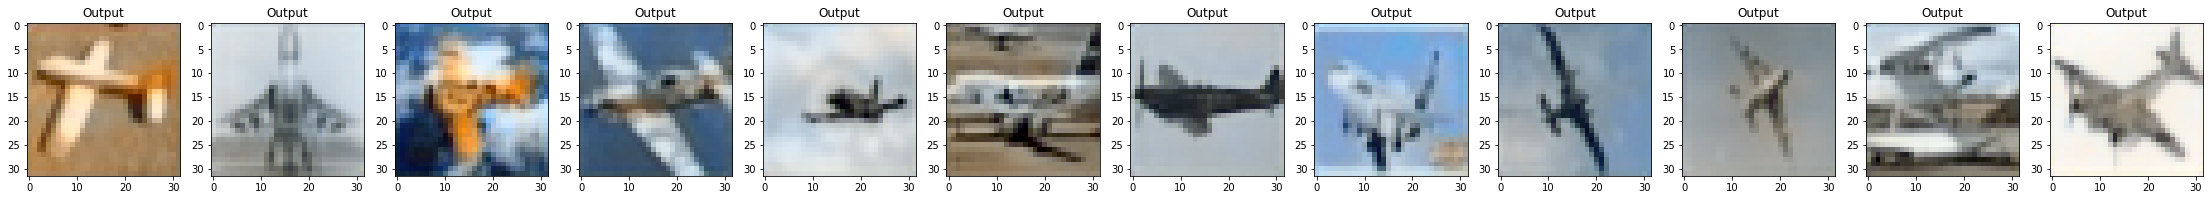

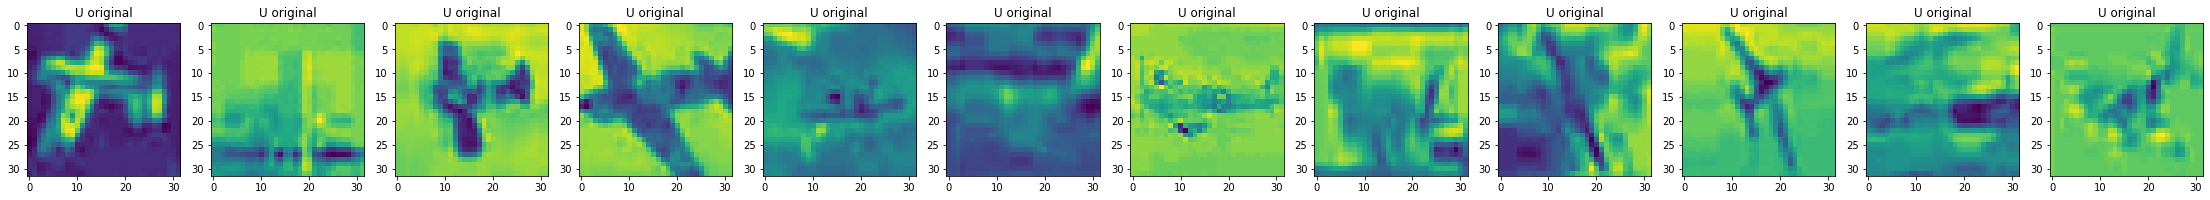

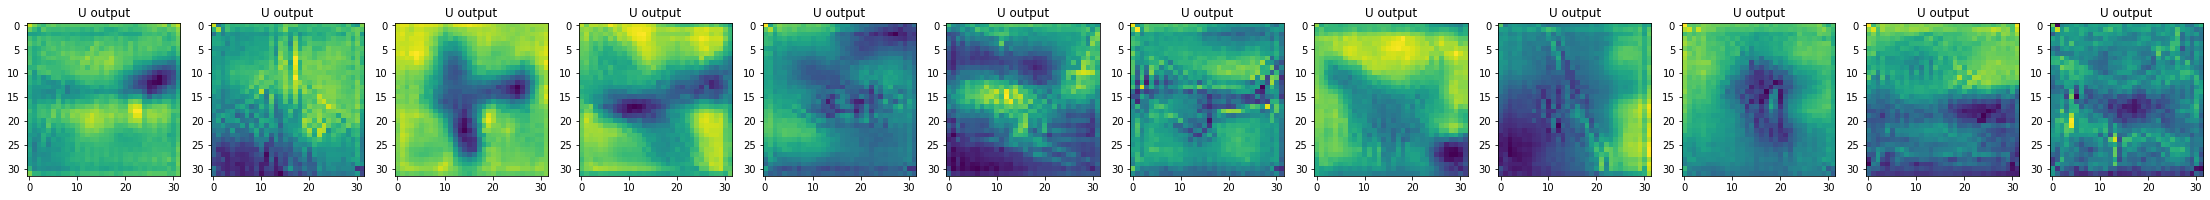

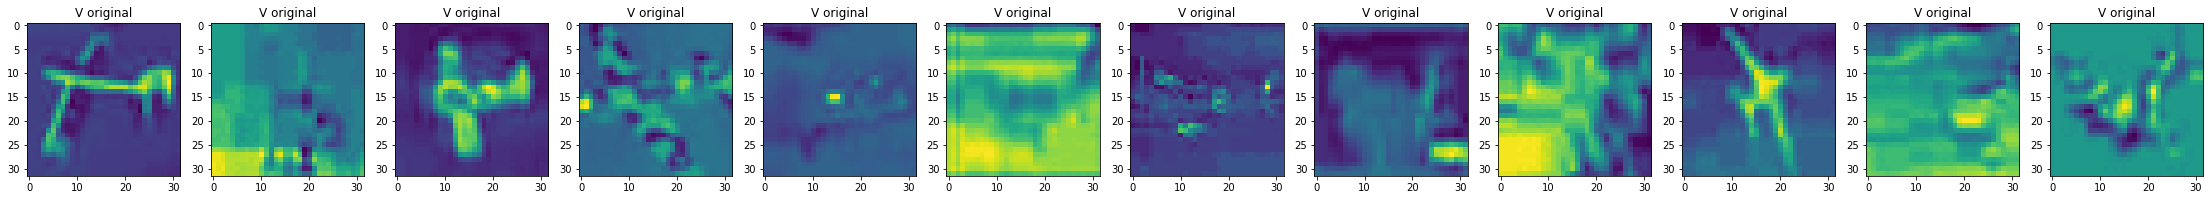

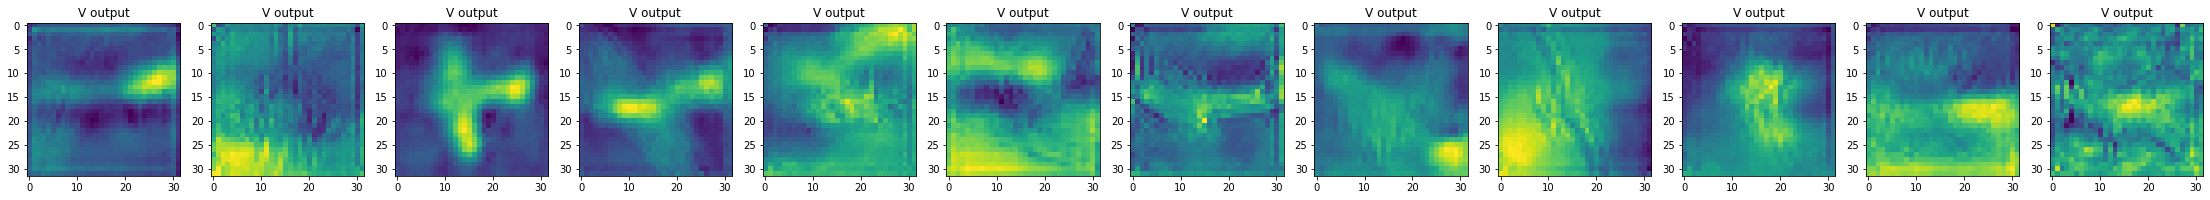

In [66]:
result = vae.predict([train_yuv, train_y])
# result = np.zeros((train_y.shape[0], 32, 32, 3))
# result[:,:,:,0] = train_y[:,:,:,0]
# result[:,:,:,1:] = output

output_count = 12
index_offset = 20

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(class_train_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])